# TPFMachine Tutorial 1.1

In [61]:
import numpy as np
import psfmachine as pm
import lightkurve as lk
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
import warnings
from scipy import sparse
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=sparse.SparseEfficiencyWarning)

## TPFs

In this tutorial we will see in depth how `TPFMachine` creates shape model, time models, and computes PSF and SAP photometry


We'll start downloading 200 TPFs around Kepler-16 observed during quarter 5

In [3]:
tpfs = lk.search_targetpixelfile('Kepler-16', mission='Kepler', quarter=5, 
                                 radius=1000, limit=200, cadence='long'
                                ).download_all(quality_bitmask=None)

Here is a visualization of a single TPF as example

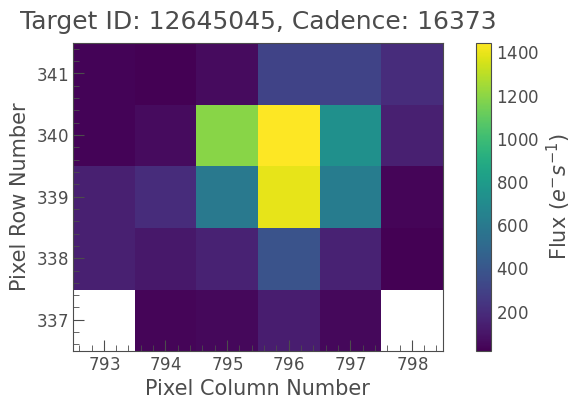

In [4]:
tpfs[52].plot();

## TPFMachine

As explained in the [LFD paper](https://ui.adsabs.harvard.edu/abs/2021AJ....162..107H/abstract), `PSFMachine` performs PSF photometry
of all sources (using Gaia as source catalog) in the TPFs. 
To create a `PSFMachine` object from TPFs, we use the submodule `TPFMachine` that includes useful methods to parse and work with 
TPF data. We'll do this using `pm.TPFMachine.from_TPFs()` which inputs a collection of TPFs. Other inputs to this method are:

* `magnitude_limit` which is the limiting magnitude to query sources in Gaia catalogs
* `dr` is the number data release, e.g. 3 for Gaia EDR3
* `renormalize_tpf_bkg` renormalize the flux values to fit a background model using [`kbackground`](https://github.com/SSDataLab/kbackground)
* \*\*kwargs for `Machine` as listed [here](https://ssdatalab.github.io/psfmachine/machine/#psfmachine.machine.Machine.__init__)

Under the hood, `pm.TPFMachine.from_TPFs()` will parse the TPF data, convert pixels coordinates into WCS, filter saturated pixels, 
removed bad cadences, query Gaia, and return a `Machine` object.

Printing the new `machine` object will tell us how many sources are in the TPFs pixels, the number of cadences, and 
total number of pixel data.

In [11]:
machine = pm.TPFMachine.from_TPFs(tpfs, magnitude_limit=18, dr=3, renormalize_tpf_bkg=True)
machine

TPFMachine (N sources, N times, N pixels): (359, 4486, 8057)

Some important `machine` attributes are:
* `machine.tpfs` and `machine.tpf_meta` have the list of original TPFs and a dictionary with TPF metadata such as quarter, channel, mission, sources in each TPF, etc.
* `machine.sources`: with a pandas.DataFrame containing the source catalog
* `machine.time`: that has a array with time values in MJD
* `flux` and `flux_err`: have the flux and flux error values of each pixel, shape is `[n_times, n_pixels]`
* `ra` and `dec`: have the RA and Dec values of each pixel, shape is `[n_pixels]`
* `column` and `row`: have the column and row values of each pixel, shape is `[n_pixels]`
* `dra` and `ddec`: have the distance in Cartesian space between pixel RA, Dec to each source in `machine.sources`, shape is `[n_sources, npixels]`
* `r` and `phi`: have the distance in Polar space between pixel RA, Dec to each source in `machine.sources`, shape is `[n_sources, npixels]`

You can see the full list of attributes (as a dictionary) doing `machine.__dict__`. Let's see and use some of them as examples:

Here's the source catalog from Gaia:

In [12]:
machine.sources

designation          ra        dec  parallax  \
0    Gaia DR3 2133262530247167616  289.324552  51.582686  1.616466   
1    Gaia DR3 2133263080002987392  289.207900  51.586092  0.504336   
2    Gaia DR3 2133263080003584128  289.205602  51.582282  0.984947   
3    Gaia DR3 2133263084302086272  289.194951  51.583371  0.883457   
4    Gaia DR3 2133263084302086784  289.196992  51.586797  0.309922   
..                            ...         ...        ...       ...   
354  Gaia DR3 2133492779152324736  288.838971  51.893487  0.821284   
355  Gaia DR3 2133492916591300864  288.889496  51.894211  0.144796   
356  Gaia DR3 2133492916591304320  288.894867  51.896601  0.648541   
357  Gaia DR3 2133492912292382976  288.893595  51.890141  2.585587   
358  Gaia DR3 2133493088390017792  288.909527  51.930597  0.841148   

     parallax_error       pmra      pmdec  phot_g_mean_flux  phot_g_mean_mag  \
0          0.032562  -2.298416 -11.012768       7062.031645        16.065042   
1          0.050699  -3.558866  -7.815627       2738.845449        17.093449   
2          0.017882  -7.581524  -6.793829      20097.434517        14.929515   
3          0.019191  -5.343587  -7.699694      16423.362618        15.148711   
4          0.017201  -4.139091  -5.795632      20483.462439        14.908858   
..              ...        ...        ...               ...              ...   
354        0.040056  -6.652471  -2.473718       3941.997142        16.698076   
355        0.069053  -1.658150  -3.073686       1581.248367        17.689867   
356        0.050593  -5.933056  -0.122113       2980.270501        17.001728   
357        0.015439 -18.046519 -29.085882     530062.957277        11.376548   
358        0.021900  -3.869092   5.411347      11906.104779        15.497943   

     phot_bp_mean_mag  phot_rp_mean_mag  phot_bp_mean_flux  phot_rp_mean_flux  \
0           16.800795         15.232625        2600.753065        6398.939581   
1           17.545729         16.499073        1309.559992        1993.098815   
2           15.299093         14.393923       10370.022892       13854.449111   
3           15.525050         14.608281        8421.642868       11372.234414   
4           15.399604         14.256479        9453.125928       15724.123963   
..                ...               ...                ...                ...   
354         17.246286         15.988624        1725.451307        3189.398445   
355         18.231911         17.057388         696.069188        1191.798859   
356         17.525383         16.370127        1334.331618        2244.435653   
357         11.654636         10.933944      297551.702144      335413.728047   
358         15.880922         14.951333        6068.033664        8291.345107   

     clean_flag    tpf_id  
0             0  12554848  
1             0      None  
2             0  12554673  
3             0  12554659  
4             0      None  
..          ...       ...  
354           0      None  
355           0      None  
356           0      None  
357           0  12689094  
358           0  12734396  

[359 rows x 15 columns]

We can visualize the skymap of TPFs

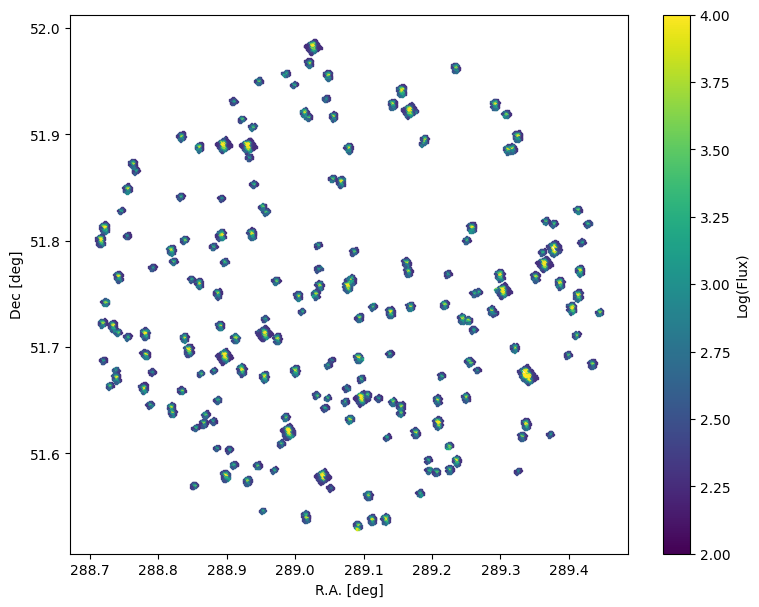

In [13]:
fig = plt.figure(figsize=(9,7))
cbar = plt.scatter(machine.ra, machine.dec, marker="s", s=1, c=np.log10(machine.flux[0]), vmin=2, vmax=4)
fig.colorbar(cbar, label="Log(Flux)")
plt.xlabel("R.A. [deg]")
plt.ylabel("Dec [deg]")
plt.show()

## Fit the Background 

We need to fit a model to the background pixels. For this `TPFMachine` uses `kbackground` which is a tool to model 
the background signal in Kepler-like data. This tool, models the background as a function of rows and time in order to
quickly model the rolling band effect seen in Kepler and K2 data.

We can model and remove the background signal by doing `machine.remove_background_model()`. This method also 
includes two diagnostic plots:
* The first one (from `kbackground`) shows the row flux data and model as a function of time, and the average flux of all background pixels as a function of time.
* The second figure shows the background pixels used to model the signal and the resulting model for a given frame. You can also make this plot with `machine.plot_background_model(frame_index=100)`.

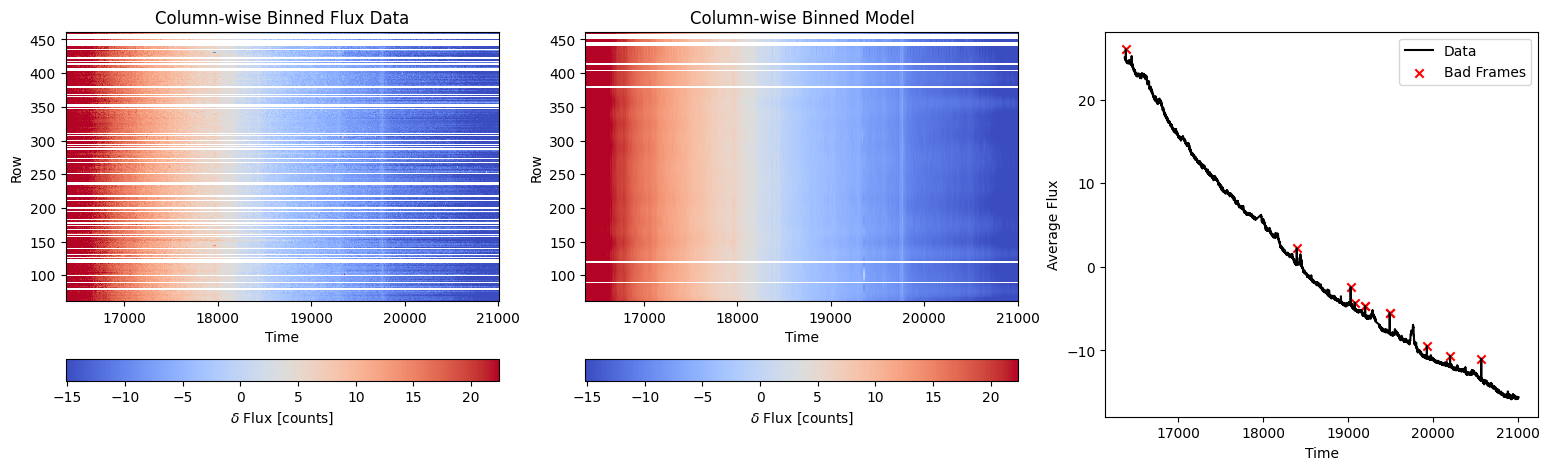

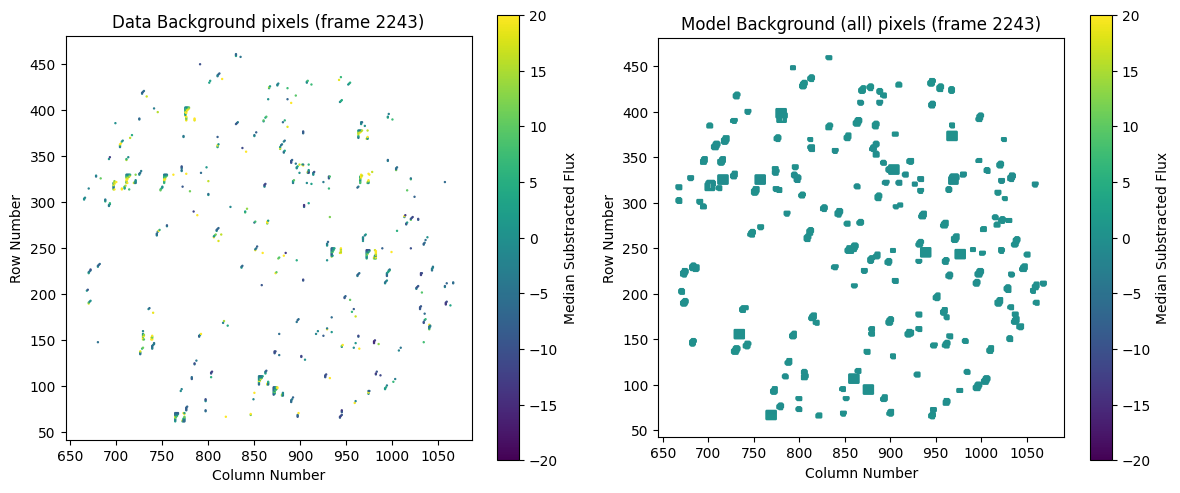

In [14]:
machine.remove_background_model(plot=True)
plt.show()

In [15]:
machine.bkg_subtracted

True

Now the TPFs are background substracted.

As an extra, you can also access the `kbackground.Estimator`:

In [16]:
machine.bkg_estimator

KBackground.Estimator

## Fit a PSF model (aka shape model)

`PSFMachine` uses all clean (noon-blended and non-saturated) source (pixels) to build a shape model of the entire scene.
This is done using the `machine.build_shape_model()` method that accepts the following parameters:
* `plot` to create a diagnostic plot with the PSF model in Cartesian and Polar coordinates
* `flux_cut_off` the normalized (time-average flux) flux value at which we stop evaluating the model, default is 1
* `upper_radius_limit` to set the upper limit on the radius at which we assume there is no flux from the source (default is 28'')
* `upper_flux_limit` and `lower_flux_limit` to set the upper and lower limits of flux to filter pixels (helps removing saturated and too faint pixels)

2023-06-09 17:31:03,426 - astroquery - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


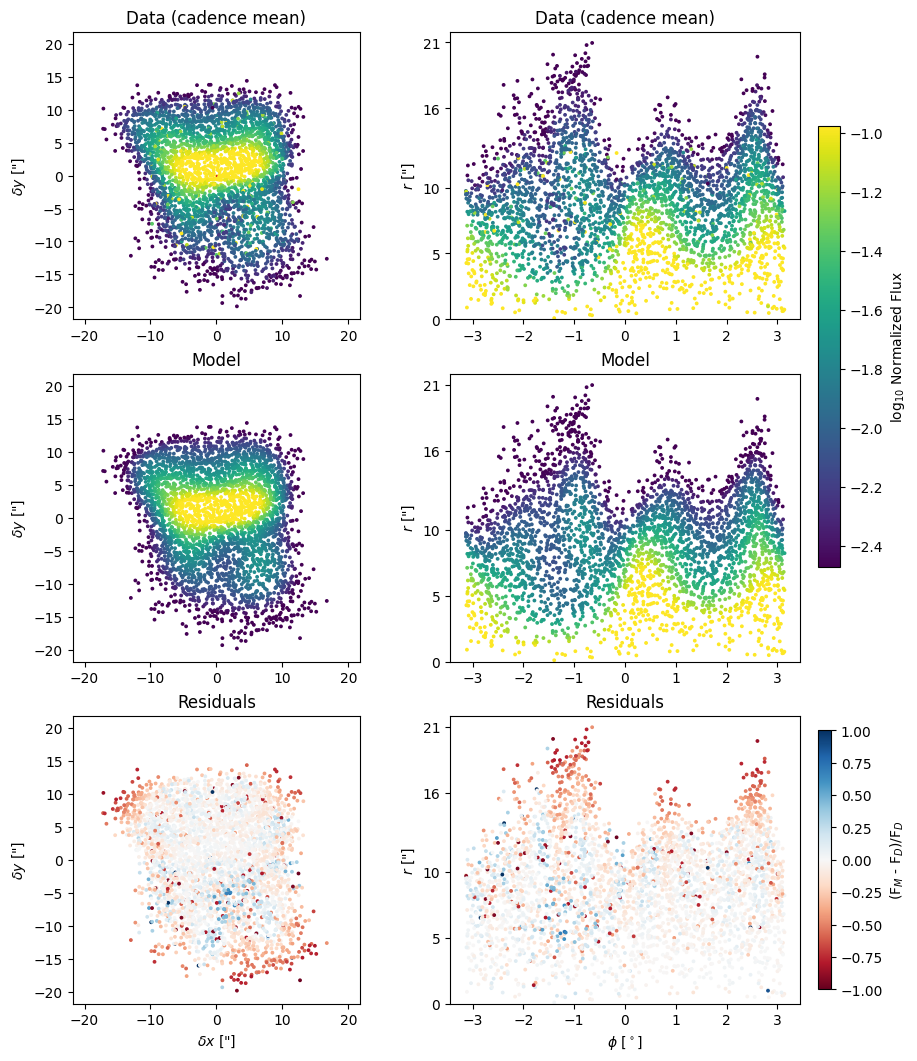

In [27]:
machine.build_shape_model(plot=True, flux_cut_off=1)
plt.show()

We can remove "background" pixels by increasing the `flux_cut_off` value.

2023-06-09 17:31:17,544 - astroquery - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


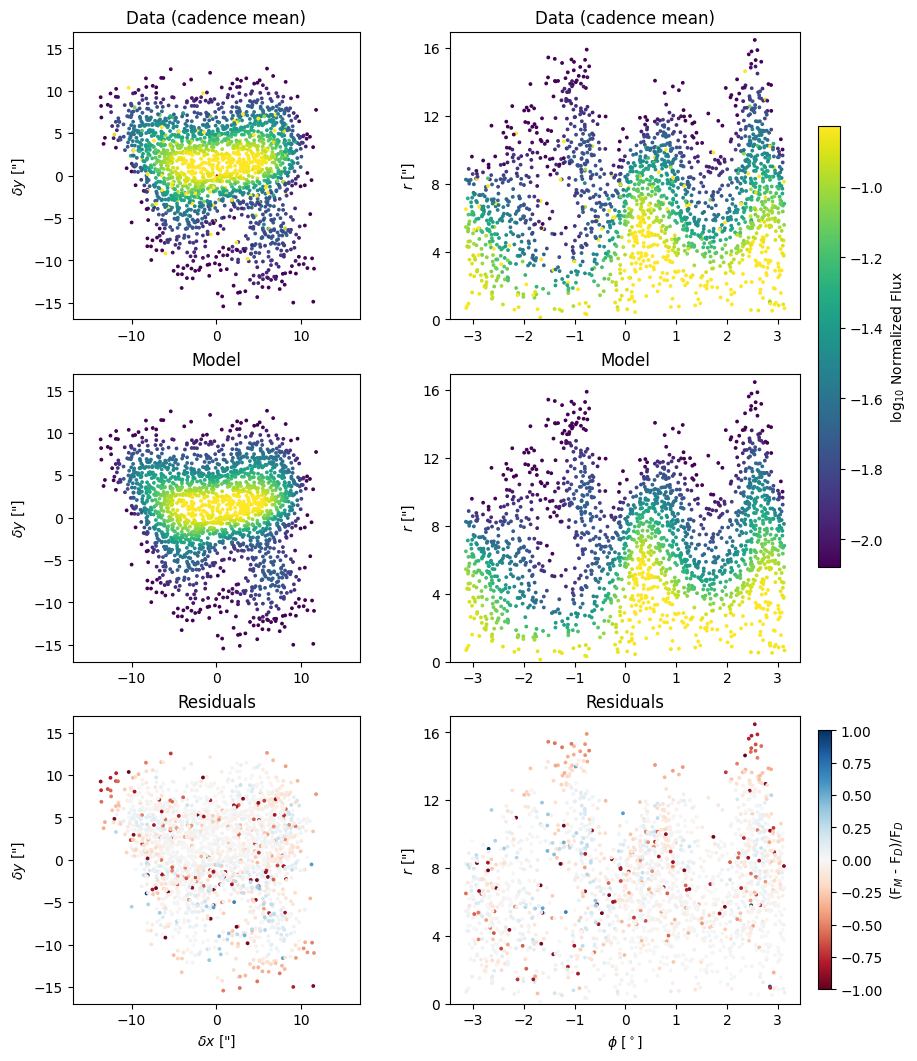

In [28]:
machine.build_shape_model(plot=True, flux_cut_off=10)
plt.show()

A shape model can also be loaded from disk if we are working with Kepler TPFs. The library includes PSF models for each channel
and quarter of observation during Kepler's mission. We can load a shape model for the TPFs we have using
`machine.load_shape_model()`. By default the corresponding channel/quarter model will be load, you can also provide a custom
model (see [Tutorial 20](Tutorial_20_FFI.ipynb) on how to buil and save FFI shape models)

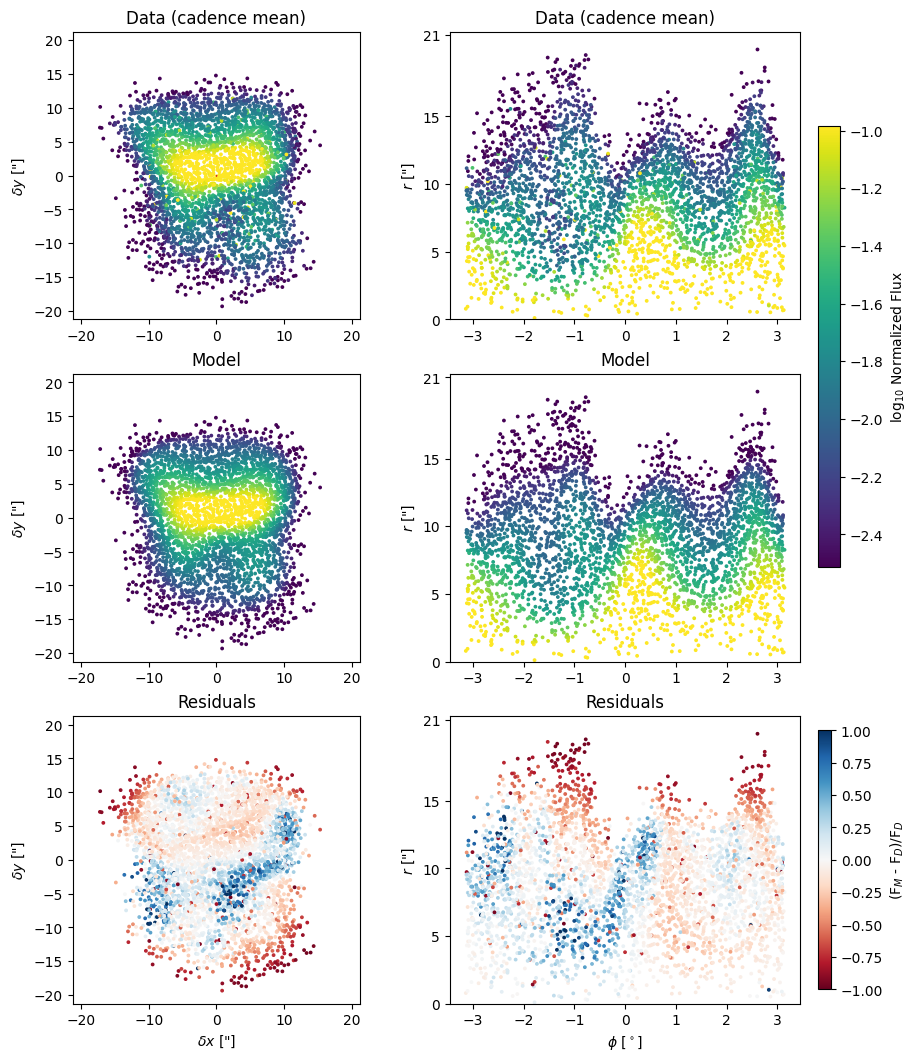

In [30]:
machine.load_shape_model(plot=True)
plt.show()

Either building or loading a shape model leave `machine` in the same state.

One interesting new attribute is `machine.mean_model` that has the mean PSF model for every source in the data. This variable is a 
`scipy.sparse.csr_matrix` and has shape `[n_sources, n_pixels]` and can be used to visualize the PSF model of a source

In [31]:
machine.mean_model

<359x8057 sparse matrix of type '<class 'numpy.float64'>'
	with 5236 stored elements in Compressed Sparse Row format>

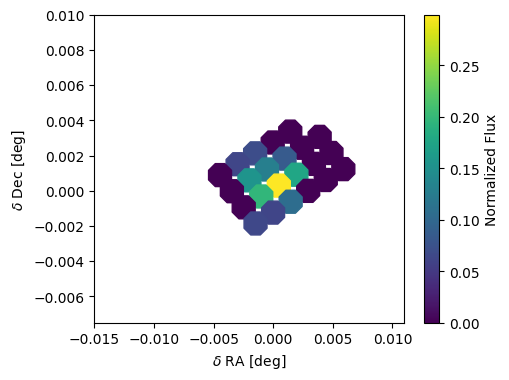

In [32]:
fig = plt.figure(figsize=(5,4))
cbar = plt.scatter(machine.dra[0], machine.ddec[0], 
                   c=machine.mean_model[0].toarray().ravel(), 
                   s=320, marker="8")
fig.colorbar(cbar, label="Normalized Flux")
plt.xlim(-.015, .011)
plt.ylim(-.0075, .01)
plt.xlabel(r"$\delta$ RA [deg]")
plt.ylabel(r"$\delta$ Dec [deg]")
plt.show()

## Fit a time model

As described [here](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-2-kepler-noise-3-seasonal-and-detector-effects.html#2.-Differential-Velocity-Aberration-and-Image-Motion)
Kepler has differential velocity aberration, this means that all sources in a relatively small section of the FOV (e.g. a portion of a CCD channel) slowly moves across the sensor, 
introducing a drift in the position of the sources. Because this is a "smooth" motion, we can model it using a regressor (time polynomial, **pos_corrs** or centroids), this is the "time model".
We can create a time model using the `machine.build_time_model()` method as with the following parameters:
* `plot` to show a diagnostic figure of the pixels used for the shape model and how their flux value change with respect to the time-averaged flux as a function of the cadences
* the following parameters are set as `machine` attributed because are also used for other methods:
    * `time_corrector` if `"pos_corr"` uses the smooth-mean pos_corr1 and pos_corr2 from the TPFs as regressors, if `"polynomial"` uses a polynomial in time, if `"centroids"` uses the scene centroids computed by `machine._get_centroids()`.
        Using the `pos_corr` is less flexible and also include extra information from the instrument and spacecraft motion, while the `poli` uses the time as base and it is more flexible.
    * `n_time_points` the number of points in the time bin that it's used to fit the time model.
    * `n_time_knots` the number of knots used in Cartesian coordinates to create the design matrix.
    * `cartesian_knot_spacing` the spacing between knots, it can be "linear" or "sqrt".
    * `time_radius` the radius around sources, out to which the velocity aberration model will be fit. (arcseconds)
    
Let's create a time model using the time polynomial:

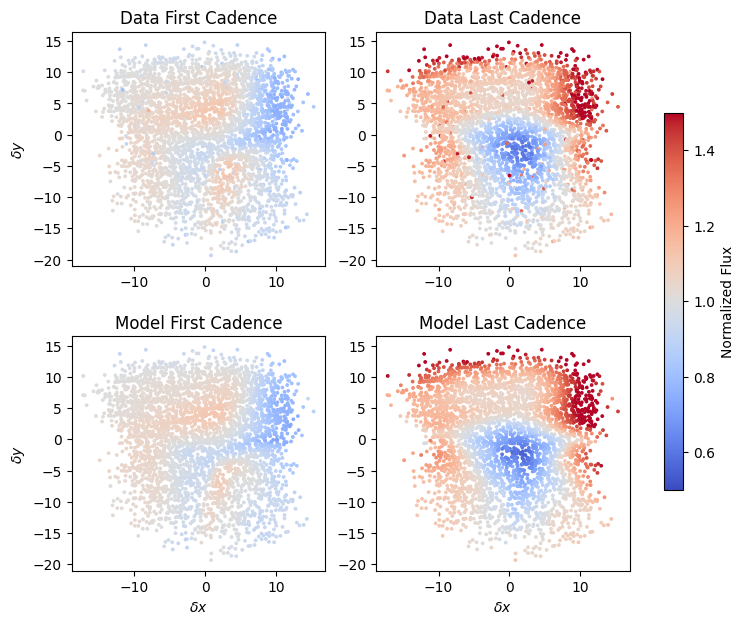

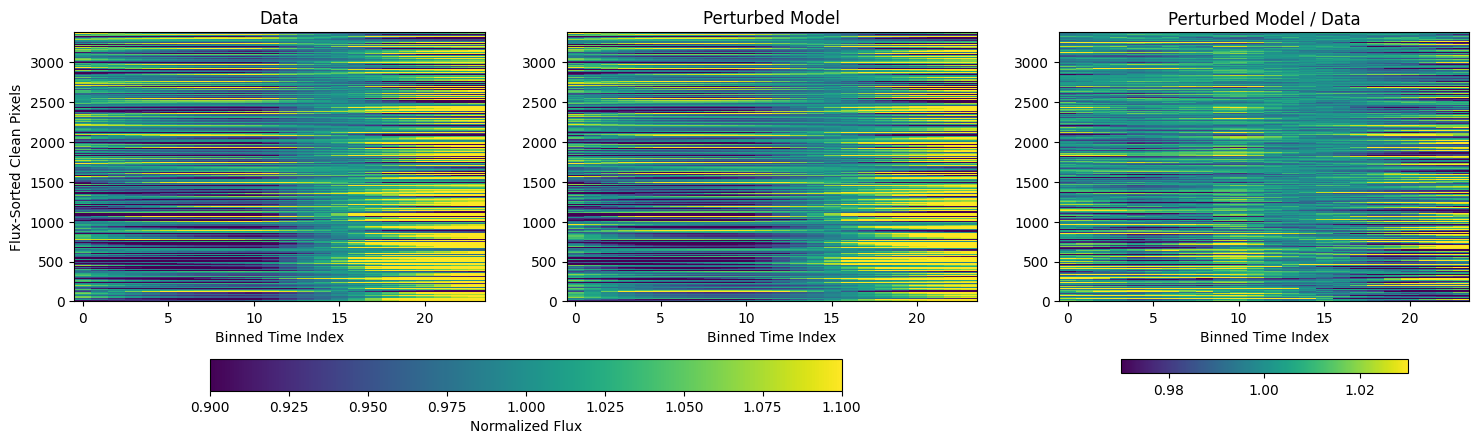

In [33]:
machine.build_time_model(plot=True)
plt.show()

The first figure shows the perturbation (aka time) model in the Cartesian space for the first and last cadence. 
The color maps deviation from the mean, with red larger values and blue smaller values.

The second figure shows the perturbation model in time (binned). 
The x-axis are is the binned time, the y-axis is pixels sorted by flux value (brighter at the top).
The panels are data (left), model (middle), and ratio (right).

Note the amplitude in the residuals is about 2%.

#### Using `poscorr` as basis

We can also use the `poscorr`'s as basis and control the time resolution of the binning with `self.time_resolution` and the amount of knots in the time axis with `time_nknots`:

2023-06-09 17:42:15,174 - psfmachine.machine - WARNING - Segments will still be used to smooth the position vectors.See https://github.com/SSDataLab/psfmachine/pull/63 for details.


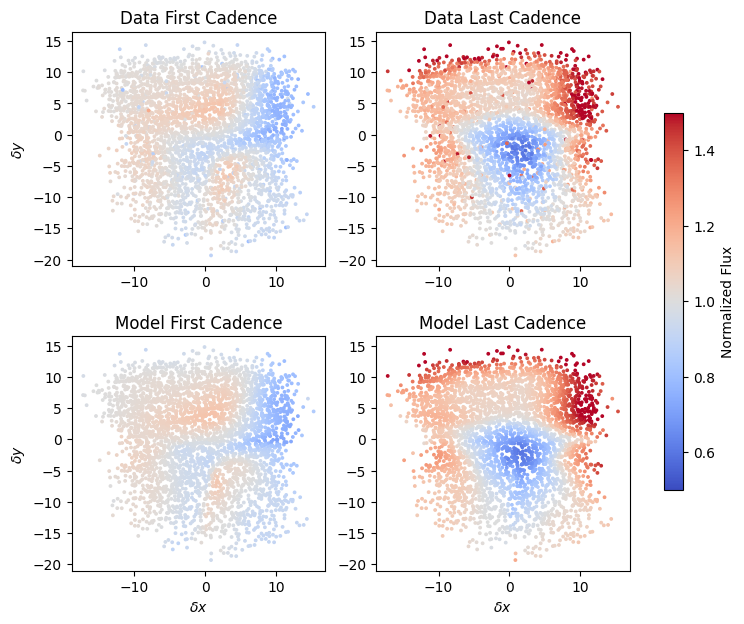

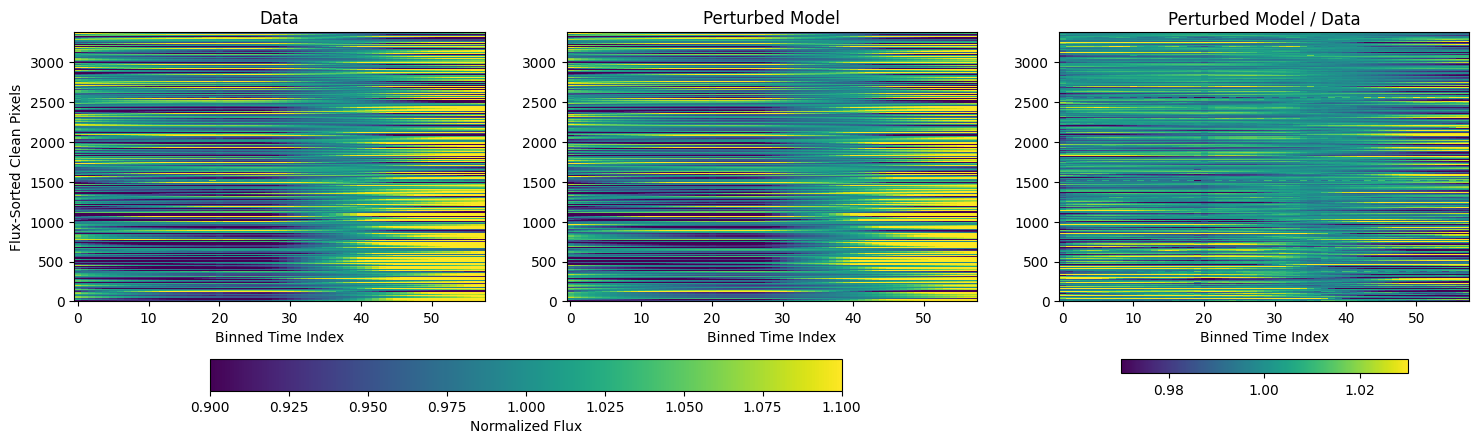

In [36]:
machine.time_resolution = 80
machine.cartesian_knot_spacing = "sqrt"
machine.time_nknots = 9
machine.build_time_model(plot=True, positions="poscorr")
plt.show()

This figure is very similar when using the time model, but later we'll see that light curves generated with this corrector have less "general trend" 
when compared to the time polynomial.

Lets visualize this `pos_corr`'s vectors:

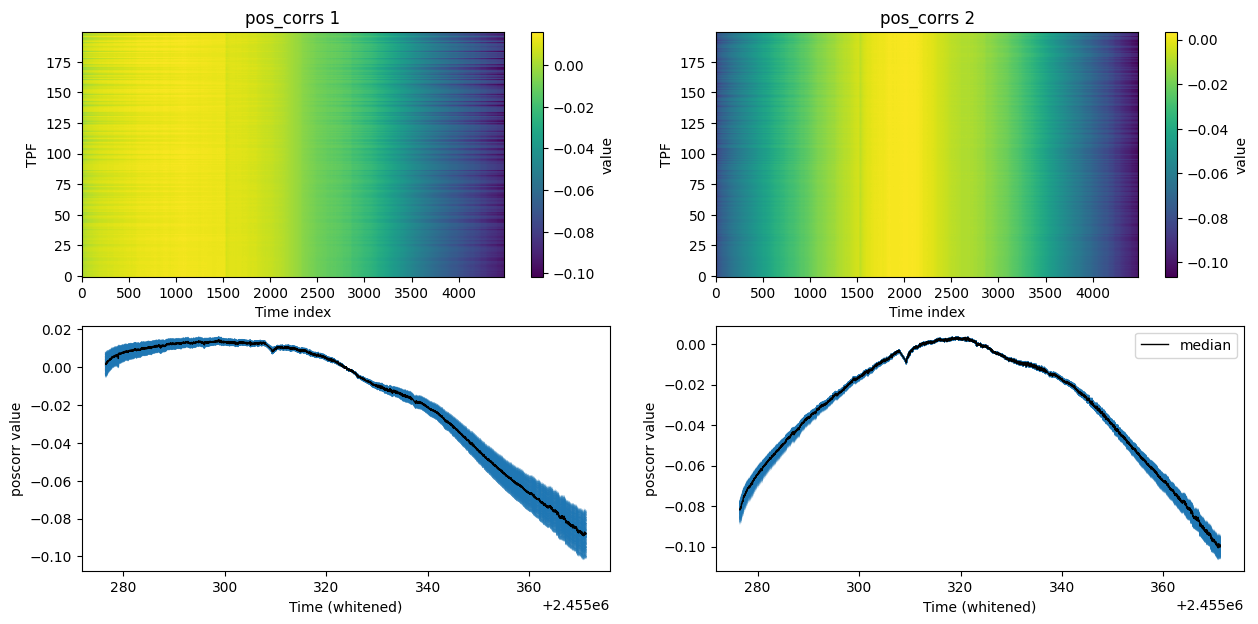

In [47]:
fig, ax = plt.subplots(2,2, figsize=(15, 7))
ax[0,0].set_title("pos_corrs 1")
cbar = ax[0,0].imshow(machine.pos_corr1, aspect="auto", origin="lower", interpolation=None)
ax[0,0].set_xlabel("Time index")
ax[0,0].set_ylabel("TPF")
fig.colorbar(cbar, ax=ax[0,0], label="value")

ax[0,1].set_title("pos_corrs 2")
cbar = ax[0,1].imshow(machine.pos_corr2, aspect="auto", origin="lower", interpolation=None)
ax[0,1].set_xlabel("Time index")
ax[0,1].set_ylabel("TPF")
fig.colorbar(cbar, ax=ax[0,1], label="value")


for k in range(machine.pos_corr1.shape[0]):
    ax[1,0].plot(machine.time, machine.pos_corr1[k], alpha=.2, lw=1, c="tab:blue")
    ax[1,1].plot(machine.time, machine.pos_corr2[k], alpha=.2, lw=1, c="tab:blue")

ax[1,0].plot(machine.time, np.nanmedian(machine.pos_corr1, axis=0), c="k", lw=1, label="median")
# ax[1,0].plot(machine.time, machine.P.vectors[:, 4], c="r", ls="-", lw=.7, label="median-smooth")
ax[1,0].set_xlabel("Time (whitened)")
ax[1,0].set_ylabel("poscorr value")

ax[1,1].plot(machine.time, np.nanmedian(machine.pos_corr2, axis=0), c="k", lw=1, label="median")
# ax[1,1].plot(machine.time, machine.P.vectors[:, 5], c="r", ls="-", lw=.7, label="median-smooth")
ax[1,1].set_xlabel("Time (whitened)")
ax[1,1].set_ylabel("poscorr value")
ax[1,1].legend(loc="best")
plt.show()

The top panels shows the `pos_corr1` and `pos_corr2` vectors for all TPFs (y axis) as a function of time.
The bottom panels also shows the median (black) value for each vector and the median values at each cadence.
We use a bspline function to smooth the median vectors to remove high-frequency noise. 
The smooth versions are used as basis to correct the source position drift.

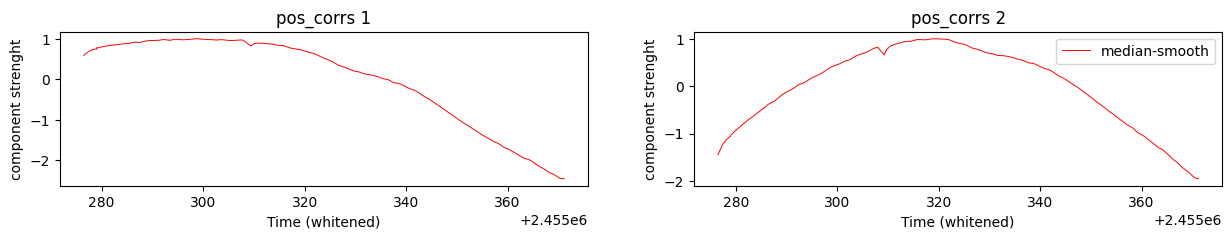

In [56]:
fig, ax = plt.subplots(1,2, figsize=(15, 2))

ax[0].set_title("pos_corrs 1")
ax[0].plot(machine.time, machine.P.vectors[:, 4], c="r", ls="-", lw=.7, label="median-smooth")
ax[0].set_xlabel("Time (whitened)")
ax[0].set_ylabel("component strenght")

ax[1].set_title("pos_corrs 2")
ax[1].plot(machine.time, machine.P.vectors[:, 5], c="r", ls="-", lw=.7, label="median-smooth")
ax[1].set_xlabel("Time (whitened)")
ax[1].set_ylabel("component strenght")
ax[1].legend(loc="best")

plt.show()

### Using CBVs as basis

We can also use the Cotrending Basis Vectors (CBVs) as basis instead.
The CBVs contain general trends and instrument systematics. These were computed by the Kepler pipeline.

In [59]:
ncomp = 4
cbv_spline_dt = 1 

# download cbv from archive
aux = lk.load_kepler_cbvs(
        mission='Kepler',
        quarter=tpfs[0].quarter,
        module=tpfs[0].module,
        output=tpfs[0].output,
    )
cbv_cdn = aux["CADENCENO"]
cbv_vec = np.vstack([aux[f"VECTOR_{i}"] for i in range(1, ncomp + 1)])

# align cadences
mask = np.isin(cbv_cdn, machine.cadenceno)
cbv_cdn = cbv_cdn[mask]
cbv_vec = cbv_vec[:, mask]

# apply b-spline smoothing
cbv_vec_smooth = pm.utils.bspline_smooth(
    cbv_vec,
    x=machine.time,
    do_segments=True,
    n_knots=int((machine.time.max() - machine.time.min()) / cbv_spline_dt),
)
other_vectors = (cbv_vec_smooth - cbv_vec_smooth.mean()) / (cbv_vec_smooth.max() - cbv_vec_smooth.mean())

Let's download these and use the first 4 components as basis.
We also can smooth out each component to avoid introducing noise to the light curves. 

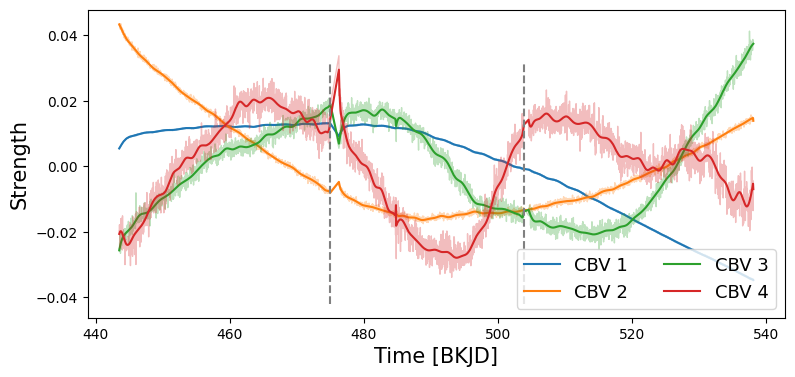

In [66]:
bkjd0 = 2454833.0

plt.figure(figsize=(9,4))
colors = cm.tab10(range(ncomp))
for k in range(ncomp):
    plt.plot(machine.time - bkjd0, cbv_vec[k], 
             c=colors[k], alpha=.3, lw=1)
    plt.plot(machine.time - bkjd0, cbv_vec_smooth[k], 
             c=colors[k], label=f"CBV {k+1}")
plt.vlines(machine.time[machine.P.breaks-1] - bkjd0, -0.042, 0.032, 
           color="gray", linestyle="--", lw=1.5)
plt.legend(loc="lower right", frameon=True, fancybox=True, 
           fontsize=13, ncols=2)
plt.xlabel("Time [BKJD]", fontsize=15)
plt.ylabel("Strength", fontsize=15)

plt.show()

Now we can build the time model

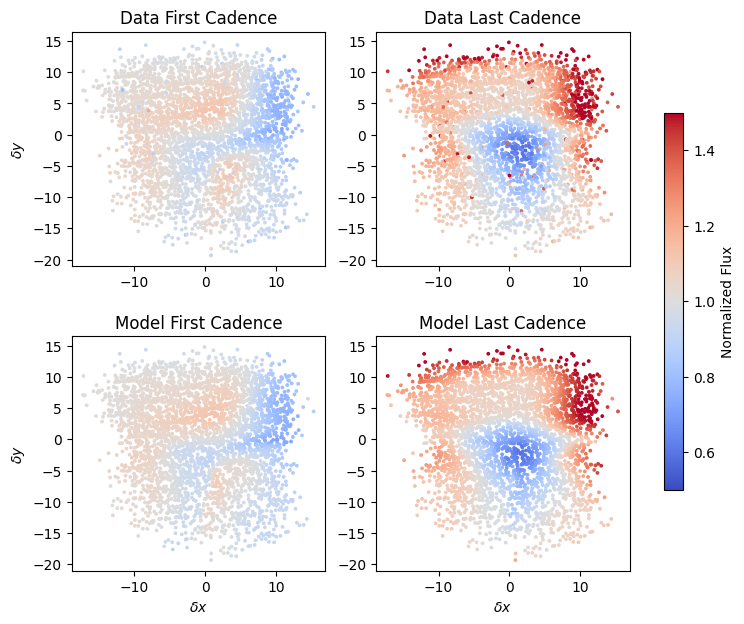

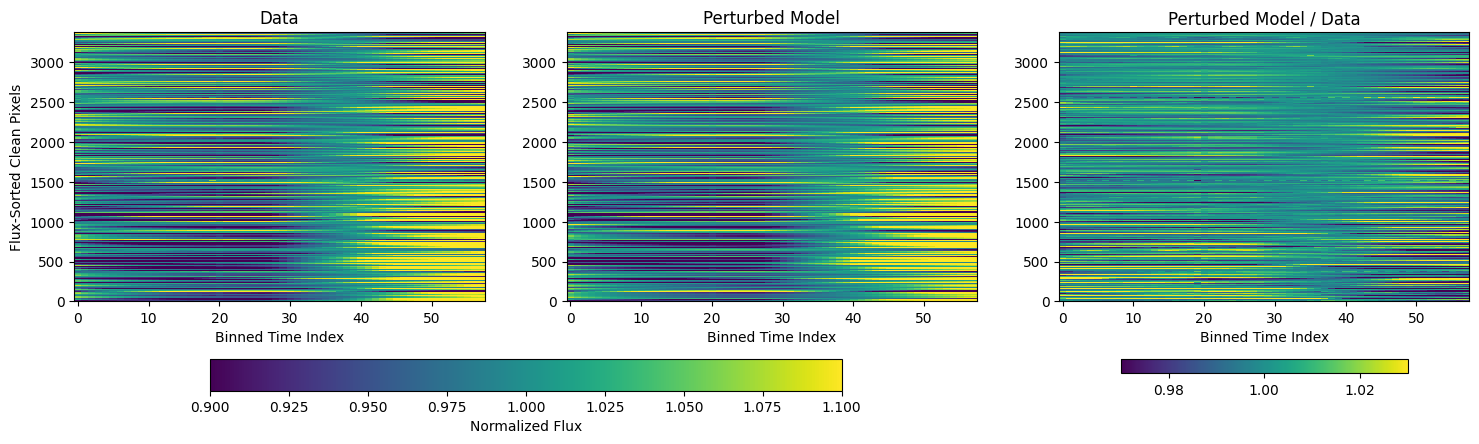

In [69]:
machine.build_time_model(other_vectors=other_vectors, plot=True)
plt.show()

## PSF photometry

Now with our shape and time model we can get PSF photometry. This is done using `machine.fit_model()` method that has the option
to use or not the "time model" by passing the `fit_va` flag.
This will create the following new attributes:
* `ws` and `werrs` have the uncorrected PSF flux and flux errors.
* `ws_va` and `werrs_va` have the PSF flux and flux errors corrected by velocity aberration.

In [70]:
machine.fit_model(fit_va=True)

Fitting 359 Sources (w. VA): 100%|█████████████████████████████████████████████████| 4486/4486 [01:45<00:00, 42.46it/s]


## Aperture Masks

`PSFMachine` can also do Aperture Photometry (aka SAP) with custom aperture masks. We use the PSF profile to define the aperture shapes, this is done
by evaluating the PSF on a source and using isophotes to define the aperture boundaries The parameter that controls the aperture size
is the percentile of the distribution values for the PSF model evaluated on a source. We find this parameter by
optimizing two metrics:
* **FLFRCSAP**: the fraction of target flux contained in the photometric aperture over the total target flux
* **CROWDSAP**: the ratio of target flux relative to the total flux within the photometric aperture including contaminating sources

We use the evaluated PSF model on all sources to compute these metrics simultaneously for all of them.

To compute SAP we use `machine.compute_aperture_photometry()` with parameters:
* `aperture_size` if `'optimal'` it will optimize the aperture to achieve the target flux metrics, if int `[0, 100]` will use the flux value
  at the provided percentile as isophote.
* `target_complete` target FLFRCSAP metric, valid values are between `[0, 1]`
* `target_crowd` target CROWDSAP metric, valid values are between `[0, 1]`

This will create the following attribuites:
* `aperture_mask` the pixel mask for each source, shape is `[n_sources, n_pixels]`
* `FLFRCSAP` and `CROWDSAP` with the resulting flux metrics for each source, shape is `[n_sources]`
* `sap_flux` and `sap_flux_err` with the flux and error values for each sources all times, shape is `[n_times, n_sources]`

In [71]:
machine.compute_aperture_photometry(aperture_size="optimal", target_complete=1, target_crowd=1)

SAP: 100%|██████████████████████████████████████████████████████████████████████████| 359/359 [00:00<00:00, 634.49it/s]


We can check how the flux metrics changes as a function of the aperture size (percentile) and where is the aperture found by the 
optimization. This figure also serves as an insight for users to choose their own `percentile` parameter, in case of wanting a
different aperture and flux metrics.

In [72]:
from psfmachine.aperture import plot_flux_metric_diagnose

In [73]:
# idx is the source index in `machine.source`
# optimal_percentile is an optional argument in case aperture_size=="optimal" in 
# machine.compute_aperture_photometry()
plot_flux_metric_diagnose(machine.mean_model, idx=0, optimal_percentile=machine.optimal_percentile[0])

<AxesSubplot: xlabel='Percentile', ylabel='Metric'>

## Source positions

`PSFMachine` includes multiple options to get the source positions (centroids), This is done with the `machine.get_source_centroids()` method
that accepts the `method` parameter which can be:
* `"aperture"` it uses the aperture mask and pixel fluxes to compute momentum centroids.
* `"poscor"` it uses the Gaia RA and Dec values converted to pixel coordinates with the TPF's WCS solutions and corrected by the `pos_corr`'s.
* `"scene"` it uses the Gaia RA and Dec values converted to pixel coordinates with the TPF's WCS solutions and corrected by the scene centroids computed in `machine._get_centroids()`.

Default is `'poscor'`. Each method creates new attributes, so you can run multiple methods and keep all results:
* `source_centroids_column_ap` and `source_centroids_row_ap` with the centroids of aperture method. By definition, this will return int values if the source got 1-pixel aperture.
* `source_centroids_column_poscor` and `source_centroids_row_poscor` with the centroids of `pos_corr` method.
* `source_centroids_column_scene` and `source_centroids_row_scene` with the centroids of `scene` method.

In [74]:
machine.get_source_centroids(method="aperture")
machine.get_source_centroids(method="poscor")
machine.get_source_centroids(method="scene")

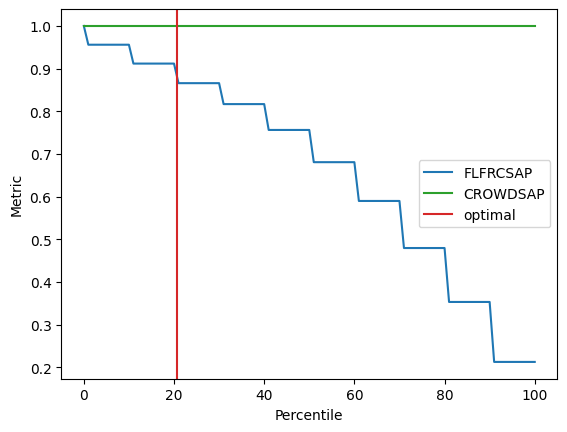

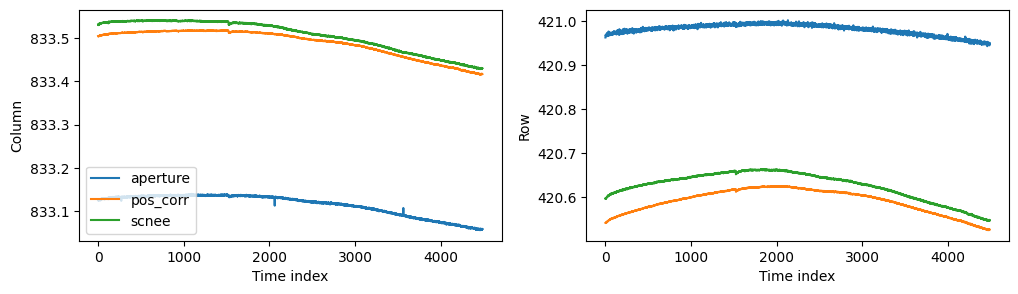

In [75]:
fix, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(machine.source_centroids_column_ap[0], label="aperture")
ax[0].plot(machine.source_centroids_column_poscor[0], label="pos_corr")
ax[0].plot(machine.source_centroids_column_scene[0], label="scnee")
ax[1].plot(machine.source_centroids_row_ap[1])
ax[1].plot(machine.source_centroids_row_poscor[1])
ax[1].plot(machine.source_centroids_row_scene[1])
ax[0].legend(loc="lower left")
ax[0].set_xlabel("Time index")
ax[0].set_ylabel("Column")
ax[1].set_xlabel("Time index")
ax[1].set_ylabel("Row")
plt.show()

## Create Light Curves

To create light curves, we just have to do `machine.fit_lightcurves()`. This method will fit a PSF model to all the sources available simultaneously,
fit a time polynomial to remove velocity aberration from the scene, and will use these two model to obtain the PSF flux. Also, the method will
do aperture photometry (SAP) on all sources where each aperture is defined accordingly to the PSF profile.
Setting `plot=True` will show diagnostic plots for the PSF model and the time model.

This method runs all the above mentioned photometry methods with default parameters and will create the new attribute `machine.lcs` with light curves as `lk.LightCurveCollection` object.

2023-06-09 18:21:25,680 - astroquery - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.
Fitting 359 Sources (w. VA): 100%|█████████████████████████████████████████████████| 4486/4486 [01:21<00:00, 54.73it/s]


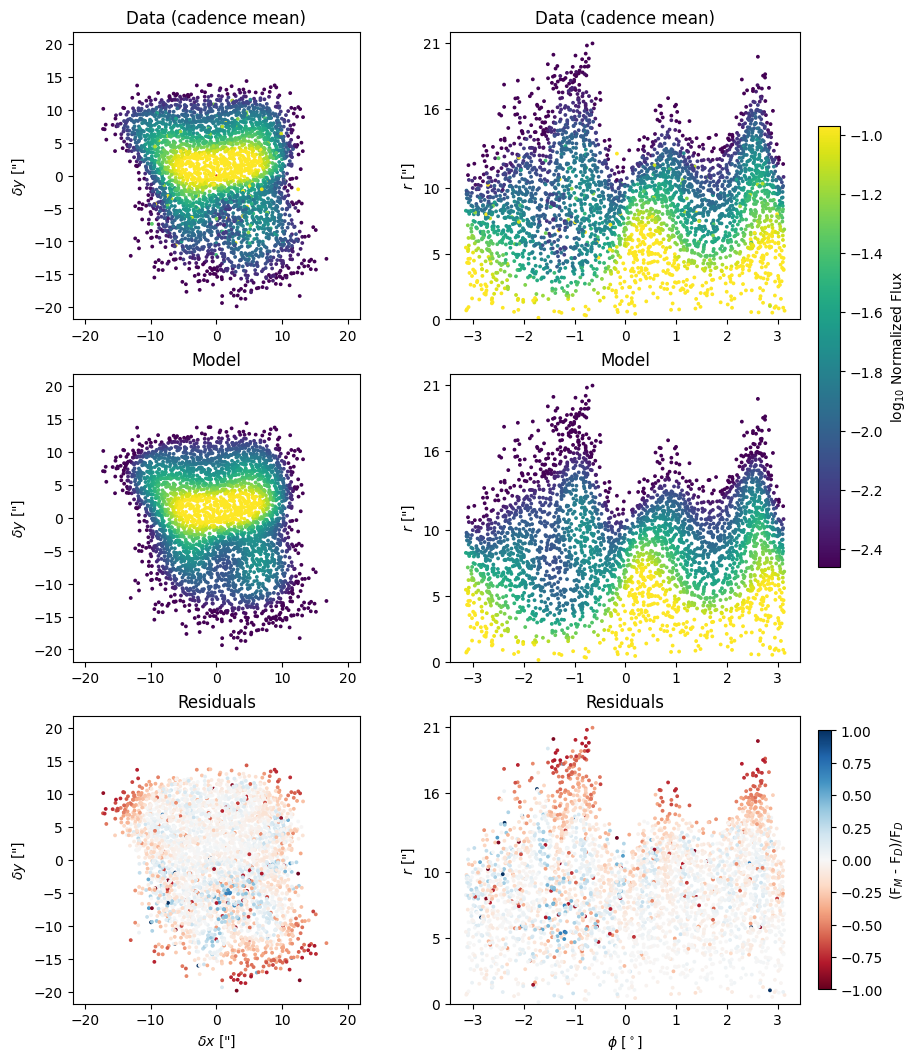

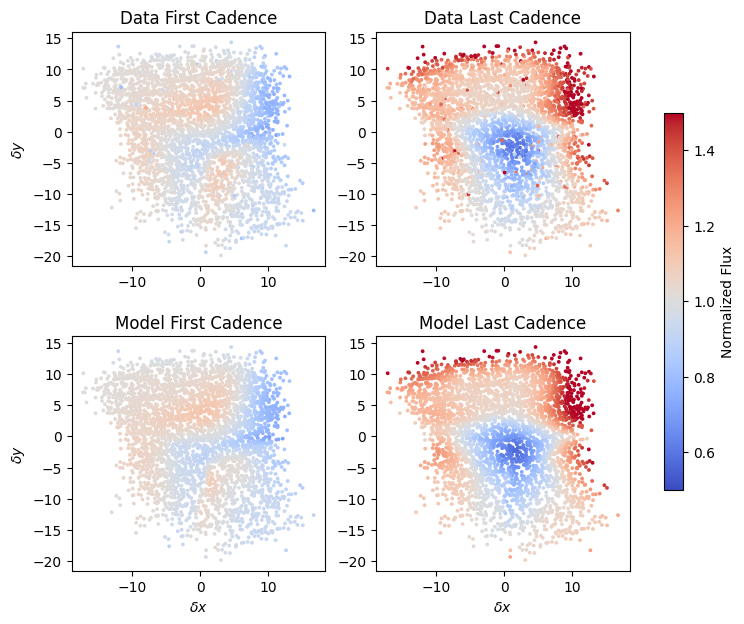

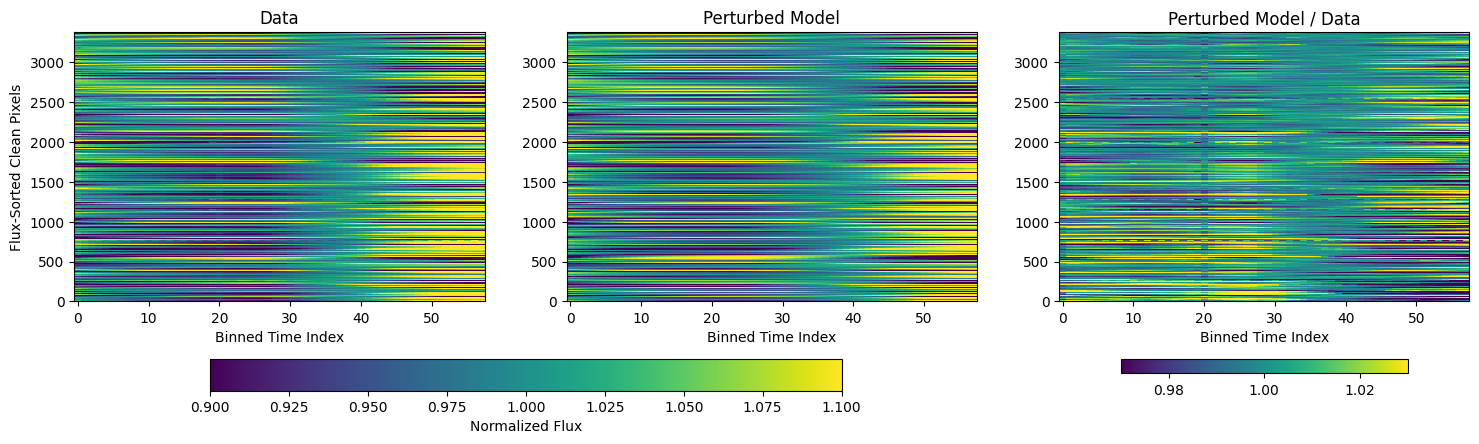

In [76]:
machine.fit_lightcurves(plot=True)
plt.show()

Let's see our new light curves:

In [77]:
machine.lcs[0]

<KeplerLightCurve length=4486 LABEL="KIC 12554848" QUARTER=5 CAMPAIGN=None>
       time               flux             flux_err      ...  psf_flux_err_NVA       sap_flux        sap_flux_err   
                      electron / s       electron / s    ...    electron / s       electron / s      electron / s   
       Time             float64            float64       ...      float64            float64           float64      
------------------ ------------------ ------------------ ... ------------------ ----------------- ------------------
2455276.4906453583 3119.0302523596147 2.6349046953708144 ...  2.634400513812833 3718.406494140625 3.4859983921051025
               ...                ...                ... ...                ...               ...                ...
2455371.1620332897  2980.726937996842  2.647833772481614 ... 2.5811363744851126 3573.540771484375  3.437415361404419

The `lightkurve` object has 7 columns:
    * `time`: the observing time in MJD
    * `flux` and `lux_err`: have the PSF photometry corrected for velocity aberration
    * `flux_NVA` and `lux_err_NVA`: have the PSF photometry without correction for velocity aberration
    * `sap_flux` and `sap_lux_err`: have the aperture photometry
    
Because each element in `self.lcs` is a `lightkurve.LightKurve` object, we can use all the functionalities the library
offers, like plotting, saving to FITS, doing periodograms, etc.

### Inspecting the Light Curves

After we got all the new light curves, we can inspect them using `machine.plot_tpf()` method which will show 
the light curves of all sources detected in a given TPF, the TPF itself with Kepler's pipeline aperture, the PSF 
models for each source and our own aperture masks for each source.

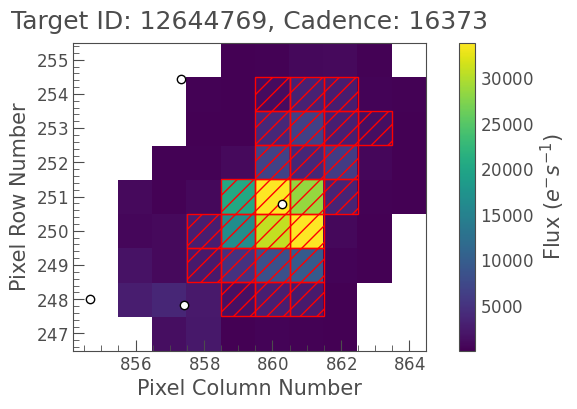

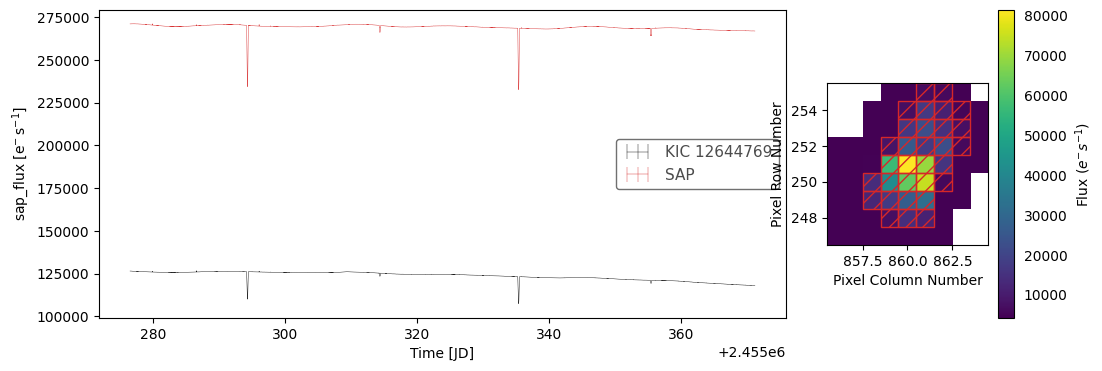

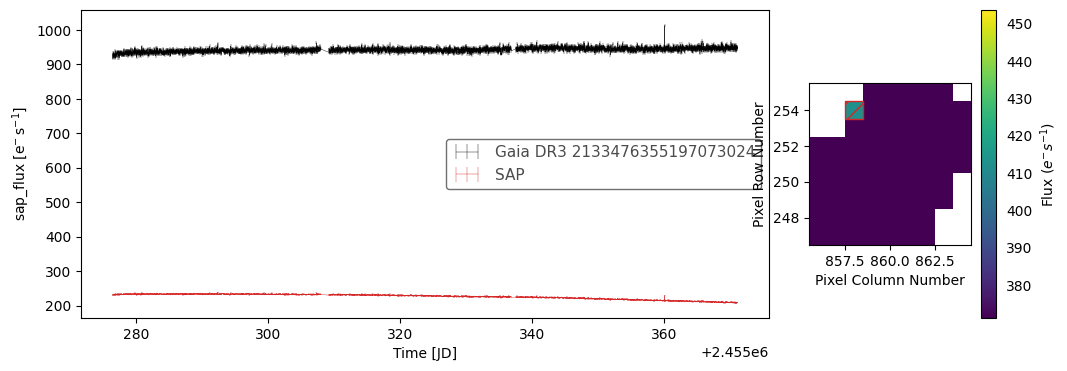

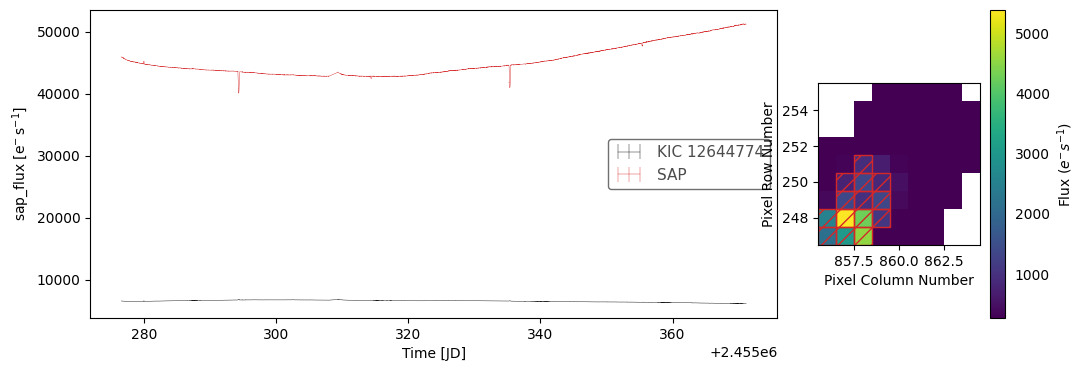

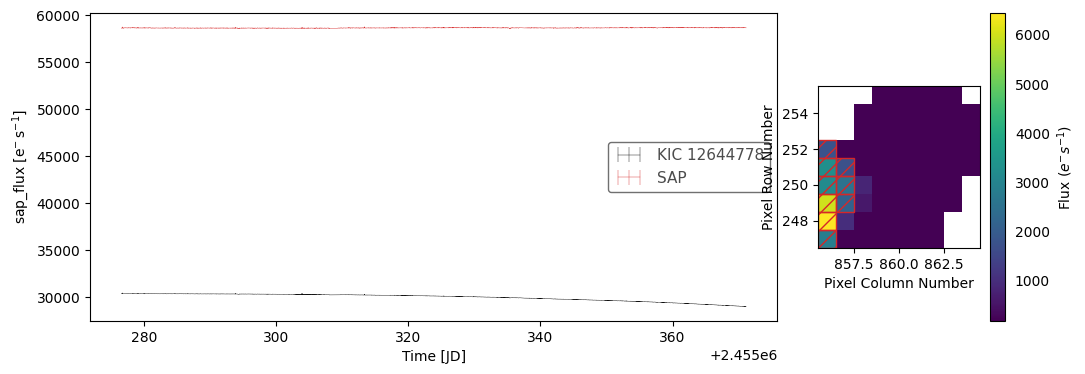

In [80]:
machine.plot_tpf(0, sap=True)
plt.show()

The first panel shows the TPF, Kepler's aperture, and sources on the TPF. The following panels show the PSF (black) and SAP (red) photometry for each source
on the TPF, as well as the evaluated PSF model and the aperture computed by `PSFMachine`.

In this case, the 3rd source at the bottom left got a slightly contaminated aperture including signal from the central target. This can be seen on the SAP (red) light curve that shows
an eclipse but the PSF (black) does not. This can be improved by choosing a smaller aperture for that particular source.

Note that PSF photmetry is generally larger than SAP (for sources fully on sensor), this is because during PSF fitting we use the Gaia g flux as prior, but Kepler's band is 
slightly different than Gaia's g band. Although, this is just a zero point correction that can be added later to obtain the absolute
flux and doe not interfere when doing relative photometry work.